### Task 3 - DBSCAN Clustering

In [1]:
# Required imports
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from itertools import product
from tabulate import tabulate
import os

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

In [2]:
# Reading the data
filename = "data_avshirod.csv"
dir_path = os.getcwd()
plt_path = dir_path + "/plots"
data = pd.read_csv(filename, header=None)

In [3]:
# Task 3 - DBSCAN clustering
# Method to calculate DBSCAN with given Epsilon and MinPts values
def dbscan1(eps, min_samples, op=True):
    db = DBSCAN(eps, min_samples).fit(data)
    labels = db.labels_
    c = Counter(labels)
    no_of_outliers = c[-1]
    no_of_clusters = len(c) - (1 if -1 in labels else 0)
    if op:
        print("DBSCAN with Epsilon = %d and MinPts = %d" % (eps, min_samples))
        print("Estimated number of clusters: %d" % no_of_clusters)
        print("Estimated number of outliers: %d" % no_of_outliers)
    return db, labels, no_of_clusters, no_of_outliers

In [4]:
# Method to run DBSCAN for varying values of Epsilon for a fixed value of MinPts
def dbscan_minpts(min_pts, op=False):
    db_temp, labels_temp, nc_temp, no_temp = [], [], [], []
    sil_score = []
    for eps in range(1,66):
        d, l, c, o = dbscan1(eps, min_pts, False)
        db_temp.append(d)
        labels_temp.append(l)
        nc_temp.append(c)
        no_temp.append(o)
        if len(Counter(l)) > 1:
            sil_score.append(metrics.silhouette_score(data, l))
        else: sil_score.append(0)
    if op:
        print("----- DBSCAN with MinPts = %d -----" % min_pts)
        print("Max Silhouette Score = %f " % max(sil_score))
        print("Optimum Eps = %d " % sil_score.index(max(sil_score)))
    return db_temp, labels_temp, nc_temp, no_temp, sil_score

Here, *DBSCAN* method from *sklearn* package is used to identify the clusters.

The method gives us the result, along with labels (as cluster ids) for the data. We can also identify the number of clusters and number of outliers for a given set of input, to gauge the correctness of inout values.

In above case, a metric given by *sklearn* package, called *Silhouette Score* is used to calculate how accurate the clustering is for given set of input pair of (Eps, Minpts).

Referring to the documentation of *[sklearn](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)*, 
 `A higher Silhouette Coefficient score relates to a model with better defined clusters.`

In [5]:
# For Minpts=3
db_3, labels_3, nc_3, no_3, ss_3 = dbscan_minpts(3, True)

----- DBSCAN with MinPts = 3 -----
Max Silhouette Score = 0.816568 
Optimum Eps = 20 


After running DBSCAN with MinPts=3 for varying values of Epsilon, we compare the Silhouette scores of all the results.

The maximum of those scores occurs for Eps = 20. We run the model with Eps = 20, MinPts = 3 and get the following output - 

In [6]:
# Run the DBSCAN algorithm for the best value of ε and Minpts=3.
db, labels,_,_ = dbscan1(20,3,True)
print(Counter(labels))

DBSCAN with Epsilon = 20 and MinPts = 3
Estimated number of clusters: 3
Estimated number of outliers: 1
Counter({0: 220, 2: 205, 1: 181, -1: 1})


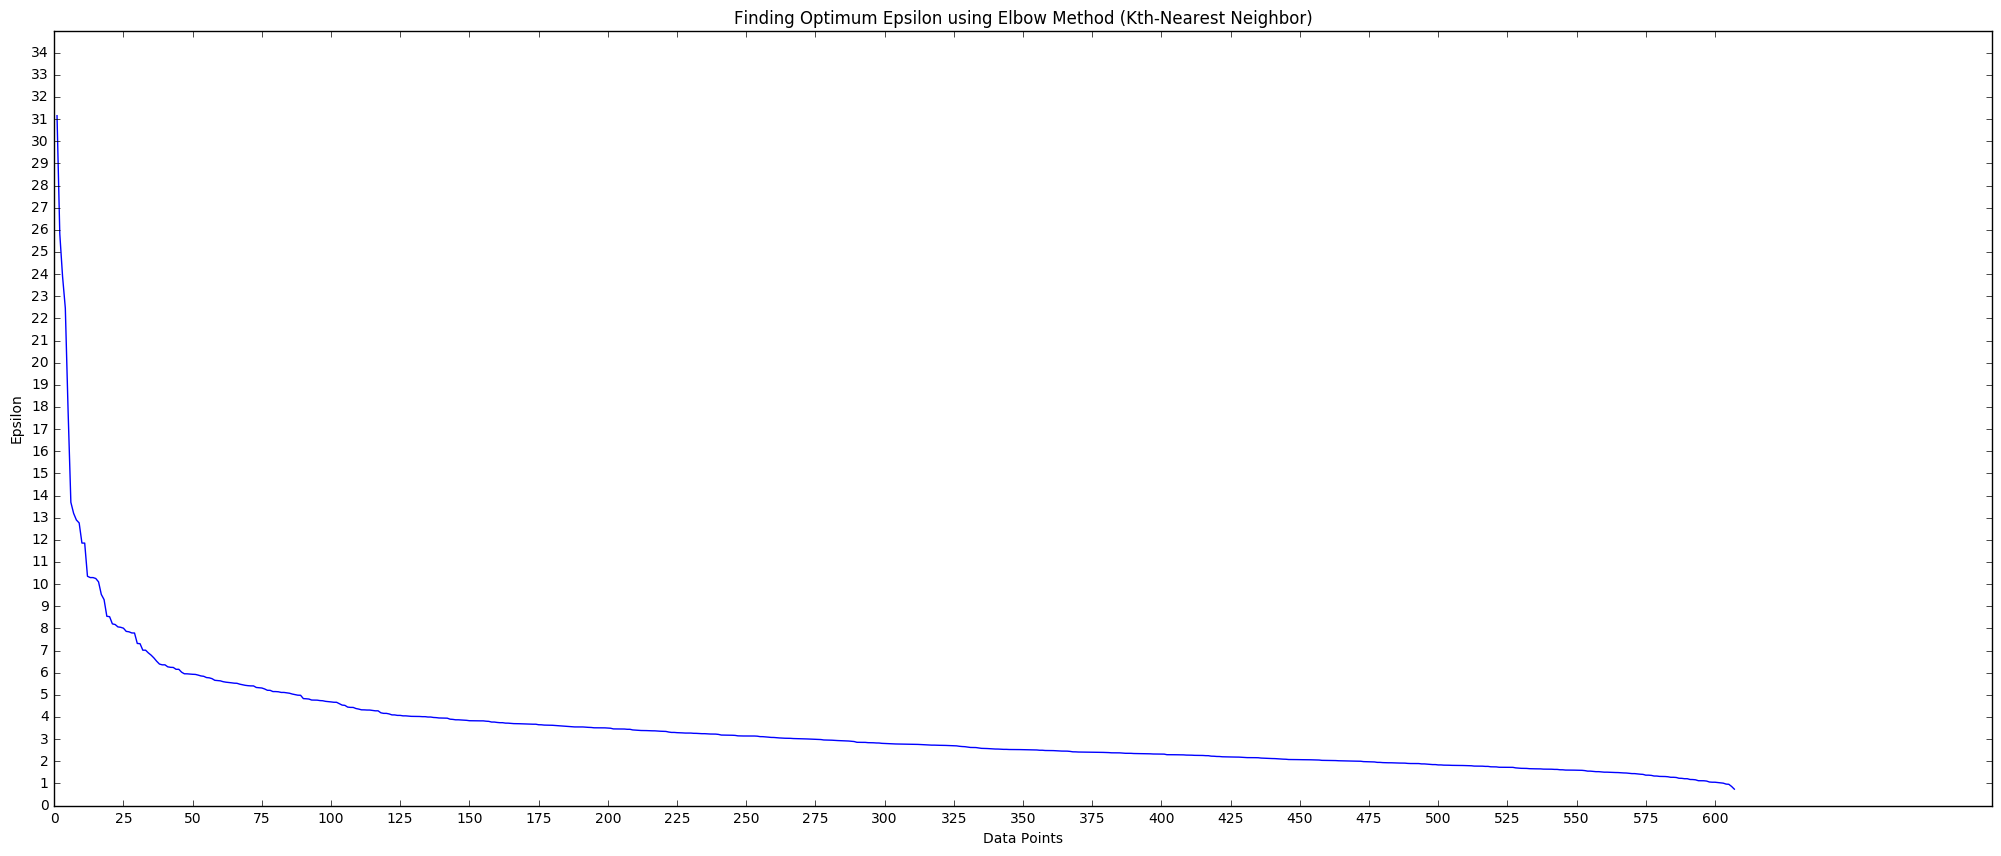

In [7]:
# Plotting k-nearest point graph to determine Epsilon Value
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=len(data)).fit(data)
distances, indices = nbrs.kneighbors(data)
max_3 = distances[:,3]
'''
from sklearn.neighbors import kneighbors_graph
np.set_printoptions(threshold=np.nan)
A = kneighbors_graph(data, 3, mode='distance', include_self=False)
# print(A.toarray())
max_3 = [max(l) for l in A.toarray()] #[:250]
'''
plt.figure(figsize = (25,10))
plt.plot(range(1,len(max_3)+1), sorted(max_3, reverse=True))
plt.title("Finding Optimum Epsilon using Elbow Method (Kth-Nearest Neighbor)")
plt.xlabel("Data Points")
plt.ylabel("Epsilon")
plt.xticks(range(0,len(max_3),25))
plt.yticks(range(0,35))
plt.show()

In [8]:
db, labels,_,_ = dbscan1(6,3,True)
print(Counter(labels))

DBSCAN with Epsilon = 6 and MinPts = 3
Estimated number of clusters: 4
Estimated number of outliers: 22
Counter({0: 210, 2: 199, 1: 169, -1: 22, 3: 7})


Looking at above graph, we can see the elbow at around 6.

After running DBSCAN for MinPts = 3 and Epsilon = 6, we see that the output is not better than what we achieved using Epsilon = 20.

Hence, we should prefer using Silhouette Score over Elbow method for finding Optimal Epsilon value.

<IPython.core.display.Javascript object>


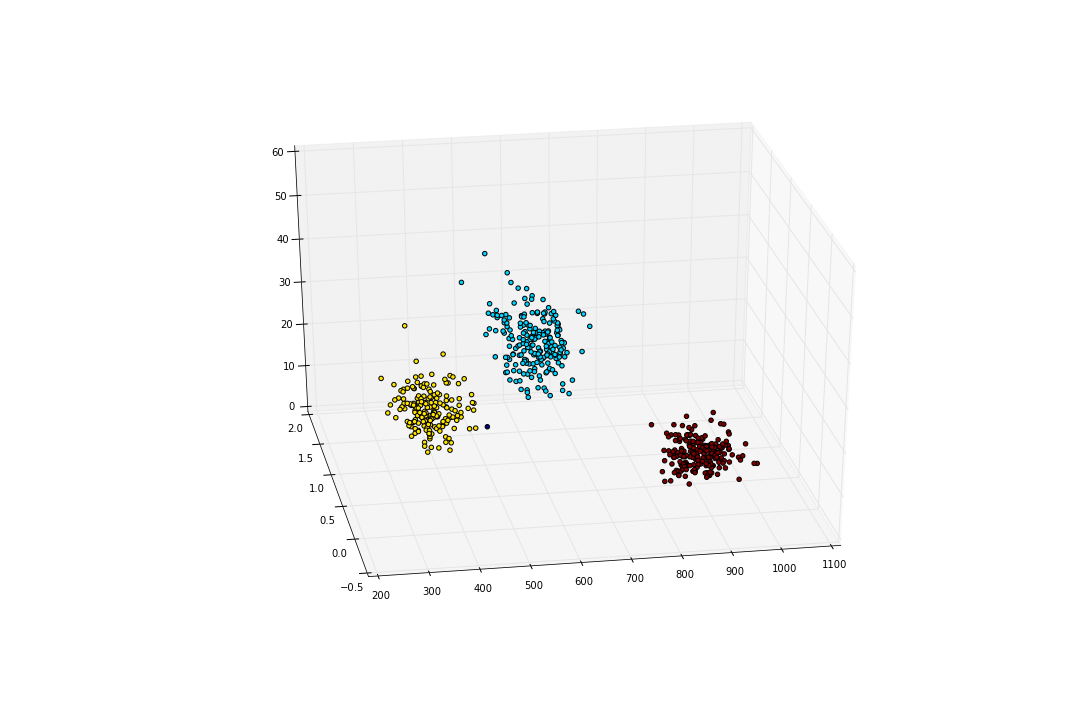

In [15]:
%matplotlib notebook
db, labels,_,_ = dbscan1(20,3,False)
# Color the data according to their cluster, and do a 3D scatter diagram. Rotate the diagram to identify the clusters.
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0], data[1], data[2], c=labels, depthshade=False)
ax.view_init(elev=30, azim=260)

As you can see in the output, and also visually in scatter plot, there is one outlier for the data.

We run the algorithm with varying values of MinPts, to get the best possible (Epsilon, MinPts) pair.
If the output shows no (or really small) improvement, then we'll stop.

In [10]:
op_minpts = []
for min_pts in range(3,11):
    db_temp, labels_temp, nc_temp, no_temp, ss_temp = dbscan_minpts(min_pts)
    op_minpts.append([min_pts, max(ss_temp), ss_temp.index(max(ss_temp))])

In [11]:
print(tabulate(op_minpts, headers=["MinPts", "Silhouette Score", "Opt Eps"], tablefmt='orgtbl'))

|   MinPts |   Silhouette Score |   Opt Eps |
|----------+--------------------+-----------|
|        3 |           0.816568 |        20 |
|        4 |           0.816568 |        21 |
|        5 |           0.816568 |        21 |
|        6 |           0.816804 |        23 |
|        7 |           0.816804 |        23 |
|        8 |           0.816804 |        23 |
|        9 |           0.816804 |        23 |
|       10 |           0.816804 |        23 |


As seen from above table, there is no significant improvement in Silhouette Score for MinPts 6 and onwards.

Hence, we can choose MinPts = 6 and the corresponding Optimum Epsilon = 23.

In [12]:
# Run the DBSCAN algorithm for the best value of ε = 23 and Minpts=6.
db, labels,_,_ = dbscan1(23,6,True)
print(Counter(labels))

DBSCAN with Epsilon = 23 and MinPts = 6
Estimated number of clusters: 3
Estimated number of outliers: 0
Counter({0: 220, 2: 205, 1: 182})


<IPython.core.display.Javascript object>


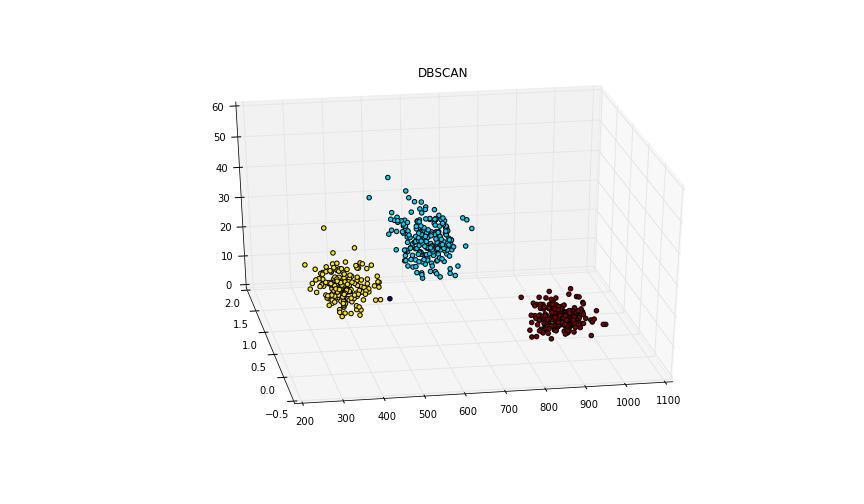

In [16]:
# Color the data according to their cluster, and do a 3D scatter diagram. Rotate the diagram to identify the clusters.
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0], data[1], data[2], c=labels, depthshade=False)
ax.view_init(elev=30, azim=260)
ax.set_title("DBSCAN")
fig.savefig(plt_path + "/t3_scatter")

In [14]:
# print(labels)
# print("Sil_Score for DBSCAN = %r " % (silhouette_score(data, labels, metric='euclidean')))

The above scatterplot shows three distinctly classified clusters.
There are no outliers as well.

Hence, our model with *(Epsilon=23, MinPts=6)* works well.